In [1]:
# for switching between GPU and CPU
NO_GPU = False

import os
from os.path import exists
if NO_GPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import keras
import keras.layers as kl
from keras.preprocessing.image import ImageDataGenerator
import scipy
import skimage, skimage.draw, skimage.transform
import random

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
def show_imgs(images, columns=9, figsize=(15,7), title=''):
    """Displays images in a grid"""
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    rows = np.ceil(len(images)/columns).astype('int')
    
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        f = plt.imshow(images[i-1], cmap=plt.cm.binary)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [5]:
def all_same_length(*args):
    """Returns True if all arguments have equal len(.)"""
    return all(len(a) == len(args[0]) for a in args)

def shuffle_together(*numpy_arrays):
    """Shuffles numpy arrays in unison, returns a tuple.
    
    (applies the same random permutation to all of them,
    so they have to be the same length on axis=0)"""
    
    assert all_same_length(*numpy_arrays)
    permut = np.random.permutation(len(numpy_arrays[0]))
    return tuple(a[permut] for a in numpy_arrays)

In [6]:
def feature_smoothen(img):
    i = scipy.ndimage.filters.gaussian_filter(img, 0.16)
    #i = scipy.ndimage.filters.uniform_filter(img)
    #i = restoration.denoise_tv_chambolle(img)
    return i

def feature_threshold(img):
    return img * (img > 0.2)

def feature_sobel(img):
    return scipy.ndimage.filters.sobel(img)
    
def feature_remove_dust(img):
    out_img = img.copy()
    labeled_img, nobjs = scipy.ndimage.label(img)
    if nobjs > 1: 
        label_count_pairs = zip(*np.unique(labeled_img, return_counts=1))
        label_count_pairs = sorted(label_count_pairs, key=lambda x: x[1], reverse=1)
        
        mask = np.zeros(img.shape)
        for i in range(nobjs):
            label, count = label_count_pairs[i]
            if i < 2 or count > 15:
                mask += (labeled_img == label)
        out_img *= mask
    return out_img

In [7]:
def feature_autoscale(img):
    
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return skimage.transform.resize(
        img[rmin:rmax, cmin: cmax],
        (28,28), order=3)

In [8]:
def normalize_arr(arr):
    return arr / np.max(arr)

def feature_histogram_vert(img):
    return normalize_arr(np.sum(img, 0))

def feature_histogram_horiz(img):
    return normalize_arr(np.sum(img, 1))

EDGES = []
EDGES.extend([(i,  0) for i in range(13, -1, -1)])
EDGES.extend([(0 , i) for i in range(28)])
EDGES.extend([(i, 27) for i in range(28)])
EDGES.extend([(27, i) for i in range(27, -1, -1)])
EDGES.extend([(i,  0) for i in range(27, 13, -1)])
MIDDLES = tuple((13 + c0 // 14, 13 + c1 // 14) for c0, c1 in EDGES)
LINES = np.asarray(tuple(map(lambda m, e: skimage.draw.line_aa(*m,*e), MIDDLES, EDGES)))

def feature_histogram_circ(img):
    sum_line = lambda line: np.sum(img[line[0], line[1]]*line[2])
    return normalize_arr(np.apply_along_axis(sum_line, -1, LINES))

def get_histogram(img):
    return np.concatenate((feature_histogram_horiz(img), 
                           feature_histogram_vert(img),
                           feature_histogram_circ(img)))

def smoothen_histogram(myarray, degree=5):
    """reference:
    https://www.swharden.com/wp/2008-11-17-linear-data-smoothing-in-python/"""
    myarray = np.pad(myarray, (degree-1,degree-1), mode='edge')
    window=degree*2-1
    weight=np.arange(-degree+1, degree)/window
    weight = np.exp(-(16*weight**2))
    weight /= sum(weight)
    smoothed = np.convolve(myarray, weight, mode='valid')
    return smoothed

In [9]:
def augment(img):
    x = skimage.transform.rotate(img,np.random.randint(-18,19), order=5)
    at = skimage.transform.AffineTransform(
        scale    = (np.random.random((2,)) - 0.4)*0.3 + 1.0,
        shear    = (np.random.random() - 0.5)*0.14,
        translation = (np.random.random((2,)) - 0.5)*4,
    )
    return skimage.transform.warp(x, at.inverse,output_shape=img.shape,order=5)

def augment_dataset(inputs, targets, augment_function, SAMPLES_PER_CATEGORY = 100000):
    
    index_map = {}
    # find indices for each category
    for i in range(len(targets)):
        categ_num = np.argmax(targets[i])
        index_map.setdefault(categ_num, []).append(i)
        
    inputs_augmented = []
    targets_augmented = []
    
    for category_num, indices in index_map.items():
        # generate the augmented samples for each category
        inputs_augmented.append(
            np.asarray(
                [augment_function(inputs[i])
                 for i in np.random.choice(indices, SAMPLES_PER_CATEGORY)])
        )
        # map the labels in another list
        targets_augmented.append(
            np.full((SAMPLES_PER_CATEGORY,),
                    fill_value=category_num)
        )
        
    # concantenate the samples and categories
    return np.concatenate(tuple(inputs_augmented)), np.concatenate(tuple(targets_augmented))

In [10]:
INPUT_SHAPE = (-1, 28, 28, 1)
VERBOSE=True

BS = 500
EPOCHS=50
GEN_KWARGS = {} #dict(samplewise_center=True, samplewise_std_normalization=True)

In [11]:
#### Import the dataset & apply transformations
fn_augm = 'augmented_images.npz'
fn_hstg = 'histograms.npz'

from urllib.request import urlretrieve
filename, headers = urlretrieve(
    'https://github.com/Avatust/my-mnist-digits/raw/master/data/digits.npz')

with np.load(filename) as data:
    x_test = data['input_data']
    y_test = data['target_data']
    
(x_train, y_train), (x_valid, y_valid) = keras.datasets.mnist.load_data()

y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test =  keras.utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0
x_ditest = np.asarray([scipy.ndimage.grey_dilation(x, size=[2,2]) for x in x_test])

try:
    print("Trying to load the BIG dataset...")
    with np.load(fn_augm) as data:
        trainX = data['input_data']
        trainY = data['target_data']
        print('{} images loaded.'.format(len(trainX)))
except:
    print("'{}' not found or something's broken, augmenting images...".format(fn_augm))
    trainX, trainY = shuffle_together(*augment_dataset(x_train, y_train, augment_function=augment))
    print("Saving {} images into '{}'...".format(len(trainX), fn_augm))
    np.savez_compressed(fn_augm, input_data=trainX, target_data=trainY)
    print("'{}' saved, done with augmentation :)".format(fn_augm))
trainY = keras.utils.to_categorical(trainY)

try:
    print("And histograms now ('{}')".format(fn_hstg))
    with np.load(fn_hstg) as data:
        Xhstg_train  = data['Xhstg_train']
        Xhstg_valid  = data['Xhstg_valid']   
        Xhstg_test   = data['Xhstg_test']   
        Xhstg_ditest = data['Xhstg_ditest']

        Yhstg_train  = data['Yhstg_train']
        Yhstg_valid  = data['Yhstg_valid']   
        Yhstg_test   = data['Yhstg_test']   
        Yhstg_ditest = data['Yhstg_ditest']
        print("Hurray!!! Histograms loaded. ({} in training DS)".format(len(Xhstg_train)))
except:
    print("Ooops... Let's make them instead.")
    Xhstg_train , Yhstg_train  = np.array(
        [get_histogram(feature_autoscale(feature_threshold(x))) for x in trainX]), trainY
    Xhstg_valid , Yhstg_valid  = np.array(
        [get_histogram(feature_autoscale(feature_threshold(x))) for x in x_valid]), y_valid
    Xhstg_test  , Yhstg_test   = np.array(
        [get_histogram(feature_autoscale(feature_threshold(x))) for x in  x_test]), y_test
    Xhstg_ditest, Yhstg_ditest = np.array(
        [get_histogram(feature_autoscale(feature_threshold(x))) for x in  x_test]), y_test
    print("That's done, now saving into '{}'".format(fn_hstg))
    np.savez_compressed(fn_hstg,
        Xhstg_train = Xhstg_train, Xhstg_valid = Xhstg_valid, Xhstg_test = Xhstg_test, Xhstg_ditest = Xhstg_ditest,
        Yhstg_train = Yhstg_train, Yhstg_valid = Yhstg_valid, Yhstg_test = Yhstg_test, Yhstg_ditest = Yhstg_ditest, )
    print("'{}' now has the histogram datasets :)".format(fn_hstg))

Trying to load the BIG dataset...
'augmented_images.npz' not found or something's broken, augmenting images...
Saving 1000000 images into 'augmented_images.npz'...
'augmented_images.npz' saved, done with augmentation :)
And histograms now ('histograms.npz')
Ooops... Let's make them instead.


/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


That's done, now saving into 'histograms.npz'
'histograms.npz' now has the histogram datasets :)


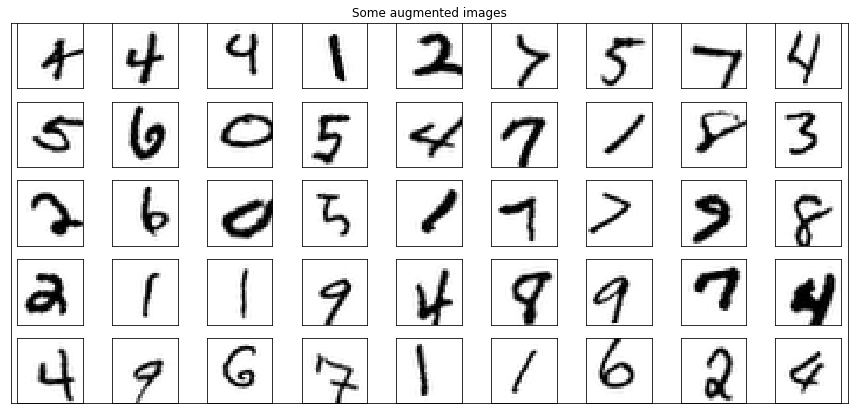

[[4 4 4 1 2 7 5 7 4]
 [5 6 0 5 4 7 1 8 3]
 [2 6 0 5 1 7 7 9 8]
 [2 1 1 9 4 8 9 7 4]
 [4 9 6 7 1 1 6 2 4]]


In [12]:
choice = np.random.choice(len(trainX), 45)
show_imgs(trainX[choice], title='Some augmented images')
print(np.apply_along_axis(np.argmax, 1, trainY[choice]).reshape(5,9))

In [13]:
# Augment, smoothen, threshold, autoscale - is a jerkier than without 'smoothen'
# Augment, autoscale - not much better and considerably slower than without autoscale
#
# Clearing the images prior to or post augmentation often removed important parts and
# did not bring clearly better results, neither did sobelization

sample_targets = np.concatenate(tuple(
    x[np.random.choice(len(x), 20)]
    for x in (x_train, x_valid, x_test, x_test_dilat))
)

show_imgs(title='Originals (training, validation, test, dilatated test)',
          columns=20, figsize=(20,4),
          images=sample_targets)

show_imgs(title='Augment - for general trainings',
          columns=20, figsize=(20,4),
          images=[
              augment(x)
              for x in sample_targets])

show_imgs(title="Augment, threshold, autoscale - for 'histograms'",
          columns=20, figsize=(20,4),
          images=[
              feature_autoscale(feature_threshold(augment(x)))
              for x in sample_targets])

show_imgs(title='Smoothen, threshold, remove dust/glyphs - too clean...',
          columns=20, figsize=(20,4),
          images=[
              feature_remove_dust(feature_threshold(feature_smoothen(x)))
              for x in sample_targets])

show_imgs(title='Sobelize - and similar turned out to be useless',
          columns=20, figsize=(20,4),
          images=[
              feature_sobel(x)
              for x in sample_targets])

NameError: name 'x_test_dilat' is not defined

In [ ]:
for i in range(5):
    im = feature_autoscale(feature_threshold(random.choice(x_train)))
    
    v =  feature_histogram_vert(im)
    h = feature_histogram_horiz(im)
    c = feature_histogram_circ(im)
        
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(4,3, width_ratios=(2, 4, 4))

    plt.subplot(gs[:, 0]); plt.imshow(im); plt.gca().axis('off')
    
    plt.subplot(gs[0, 1]); plt.plot(v, '+', label='Vertical histogram'); plt.legend()
    
    plt.subplot(gs[0, 2]); plt.plot(h, '+', label='Horizontal histogram'); plt.legend();
    
    plt.subplot(gs[1, 1:]); plt.plot(c, '+', label='I would call it a circular histogram'); plt.legend();
    
    plt.subplot(gs[2, 1]); plt.plot(smoothen_histogram(v), '+', label='Vertical histogram (smoothed)'); plt.legend();
    
    plt.subplot(gs[2, 2]); plt.plot(smoothen_histogram(h), '+', label='Horizontal histogram (smoothed)'); plt.legend();
    
    plt.subplot(gs[3, 1:]); plt.plot(smoothen_histogram(c), '+', label='I would call it a circular histogram (smoothed)'); plt.legend();
    
    plt.show()
    print('\n\n')


In [ ]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple = build_model(
    kl.InputLayer((28,28,1)),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.Dropout(0.2),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dropout(0.2),
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple = model_simple.fit(x_train_no_dust.reshape(INPUT_SHAPE), y_train,
                               validation_data=(x_valid_no_dust.reshape(INPUT_SHAPE), y_valid),
                               epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
print('Eval:', model_simple.evaluate(x_test_no_dust.reshape(INPUT_SHAPE), y_test, verbose=0))

plot_history(hist_simple, start_x_from=5)

In [ ]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple_autoscale = build_model(
    kl.InputLayer((28,28,1)),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.Dropout(0.2),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dropout(0.2),
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple_autoscale = model_simple_autoscale.fit(x_train_no_dust_autoscaled.reshape(INPUT_SHAPE), y_train,
                               validation_data=(x_test_no_dust_autoscaled.reshape(INPUT_SHAPE), y_test),
                               epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
print('Eval:', model_simple_autoscale.evaluate(x_test_no_dust_autoscaled.reshape(INPUT_SHAPE), y_test, verbose=0))

plot_history(hist_simple_autoscale, start_x_from=5)

In [ ]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple_sobel = build_model(
    kl.InputLayer((28,28,1)),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.Dropout(0.2),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dropout(0.2),
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple_sobel = model_simple_sobel.fit(x_train_no_dust_sobel.reshape(INPUT_SHAPE), y_train,
                               validation_data=(x_test_no_dust_sobel.reshape(INPUT_SHAPE), y_test),
                               epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
print('Eval:', model_simple_sobel.evaluate(x_test_no_dust_sobel.reshape(INPUT_SHAPE), y_test, verbose=0))

plot_history(hist_simple_sobel, start_x_from=5)

In [ ]:
model_lentil_reg = build_model(
    kl.InputLayer((28,28,1)),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Conv2D(filters=40, kernel_size=3, padding='same', activation='relu'),
    kl.Dropout(0.1),
    kl.MaxPool2D(pool_size=2, strides=2),


    kl.Conv2D(filters=50, kernel_size=5, padding='same', activation='relu'),
    kl.Dropout(0.1),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dropout(0.1),
    kl.Dense(units=200, activation='relu'),
    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lentil_reg = model_lentil_reg.fit_generator(generator=train_data_flow,
                                    validation_data=test_data_flow,
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=40, verbose=1)

In [ ]:
print('Eval:', model_lentil_reg.evaluate_generator(test_data_flow))

plot_history(hist_lentil_reg, start_x_from=5)

In [ ]:
model_just_dense = build_model(
    kl.InputLayer((168,)),
    
    kl.Dense(units=170, activation='elu'),
    kl.Dropout(0.2),
    kl.Dense(units=120, activation='elu'),
    kl.Dropout(0.1),
    kl.Dense(units=80, activation='elu'),
    kl.Dropout(0.1),
    kl.Dense(units=80, activation='elu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

#hist_just_dense = model_just_dense.fit(x_train_histograms, y_train,
#                                       validation_data=(x_test_histograms, y_test),
#                                       epochs=300, batch_size=2000, verbose=VERBOSE)

In [ ]:
hist_just_dense = model_just_dense.fit_generator(generator=train_data_flow_hist,
                                    validation_data=(x_test_histograms, y_test),
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=40, verbose=1)

print('Eval:', model_just_dense.evaluate(x_test_histograms, y_test))


plot_history(hist_just_dense, start_x_from=5)

In [ ]:
model_just_dense = build_model(
    kl.InputLayer((168,1)),
    kl.Flatten(),
    
    kl.Dense(units=168, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dropout(0.1),
    kl.Dense(units=168, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dense(units=100, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dropout(0.1),
    kl.Dense(units=60, activation='relu', kernel_constraint=keras.constraints.max_norm(3)),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

In [ ]:
nexttrain_data_flow_hist)[0].shape

In [ ]:
hist_just_dense = model_just_dense.fit(x_train_histograms.reshape(-1, 168, 1), y_train,
                                       validation_data=(x_test_histograms.reshape(-1, 168, 1), y_test),
                                       epochs=500, batch_size=20000, verbose=VERBOSE)
print('Eval:', model_just_dense.evaluate(x_test_histograms.reshape(-1, 168, 1), y_test))


plot_history(hist_just_dense, start_x_from=0)